In [1]:
import os
import copy
import pickle

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch.nn as nn
from tqdm.auto import tqdm
from sklearn.cluster import KMeans

import multitask.dataset as dataset
from multitask.models.task_switching import get_task_model
import multitask.models.task_switching.hooks as hooks
from multitask.utils.training import get_device
from multitask.utils.argparse import check_runs

In [2]:
sns.set_theme(style='ticks', palette='pastel')
mpl.rcParams['font.family'] = 'Liberation Sans'

In [3]:
path_data = os.path.join('..', '..', 'data')
path_model_task_switching = os.path.join('..', '..', 'results', 'task_switching')
path_figure_tasks = os.path.join('svg', 'figure07_neural_selectivity_tasks.svg')
path_figure_removed = os.path.join('svg', 'figure07_neural_selectivity_removed.svg')

In [4]:
num_runs = 10
initial_seed = 6789
max_seed = 10e5
num_epochs = 50
num_hidden = 10 * [100]
batch_size = 100
num_train = 50000
num_test = 10000
tasks_names = ['parity', 'value']
idxs_contexts = list(range(len(num_hidden)))

In [5]:
parameters = {
    'num_runs': num_runs,
    'initial_seed': initial_seed,
    'max_seed': max_seed,
    'num_epochs': num_epochs,
    'num_hidden': num_hidden,
    'batch_size': batch_size,
    'num_train': num_train,
    'num_test': num_test,
    'tasks': tasks_names,
    'idxs_contexts': idxs_contexts
}

data_folder = check_runs(path_model_task_switching, parameters)

Found simulation in ../../results/task_switching with the same parameters (2022-09-28_02_23_14)


In [6]:
pickle_data = os.path.join(data_folder, 'data.pickle')
with open(pickle_data, 'rb') as handle:
    results_task_switching = pickle.load(handle)

In [7]:
seeds = sorted(list(results_task_switching.keys()))
num_seeds = len(seeds)
num_tasks = len(tasks_names)

print(seeds)
print(tasks_names)

[10612, 17350, 130146, 173249, 213794, 341996, 440064, 668870, 858781, 894813]
['parity', 'value']


In [8]:
tasks_datasets = dataset.get_tasks_dict(tasks_names, root=path_data)

task_switching_tasks = {}
num_tasks = len(tasks_names)

for i_context, task_name in enumerate(tasks_names):
    task_switching_tasks[task_name] = {}
    task_switching_tasks[task_name]['data'] = tasks_datasets[task_name]
    task_switching_tasks[task_name]['activations'] = num_tasks * [0]
    task_switching_tasks[task_name]['activations'][i_context] = 1

for key, value in task_switching_tasks.items():
    print(f'{key}: {value["activations"]}')

parity: [1, 0]
value: [0, 1]


Running on CPU.


  0%|          | 0/10 [00:00<?, ?it/s]

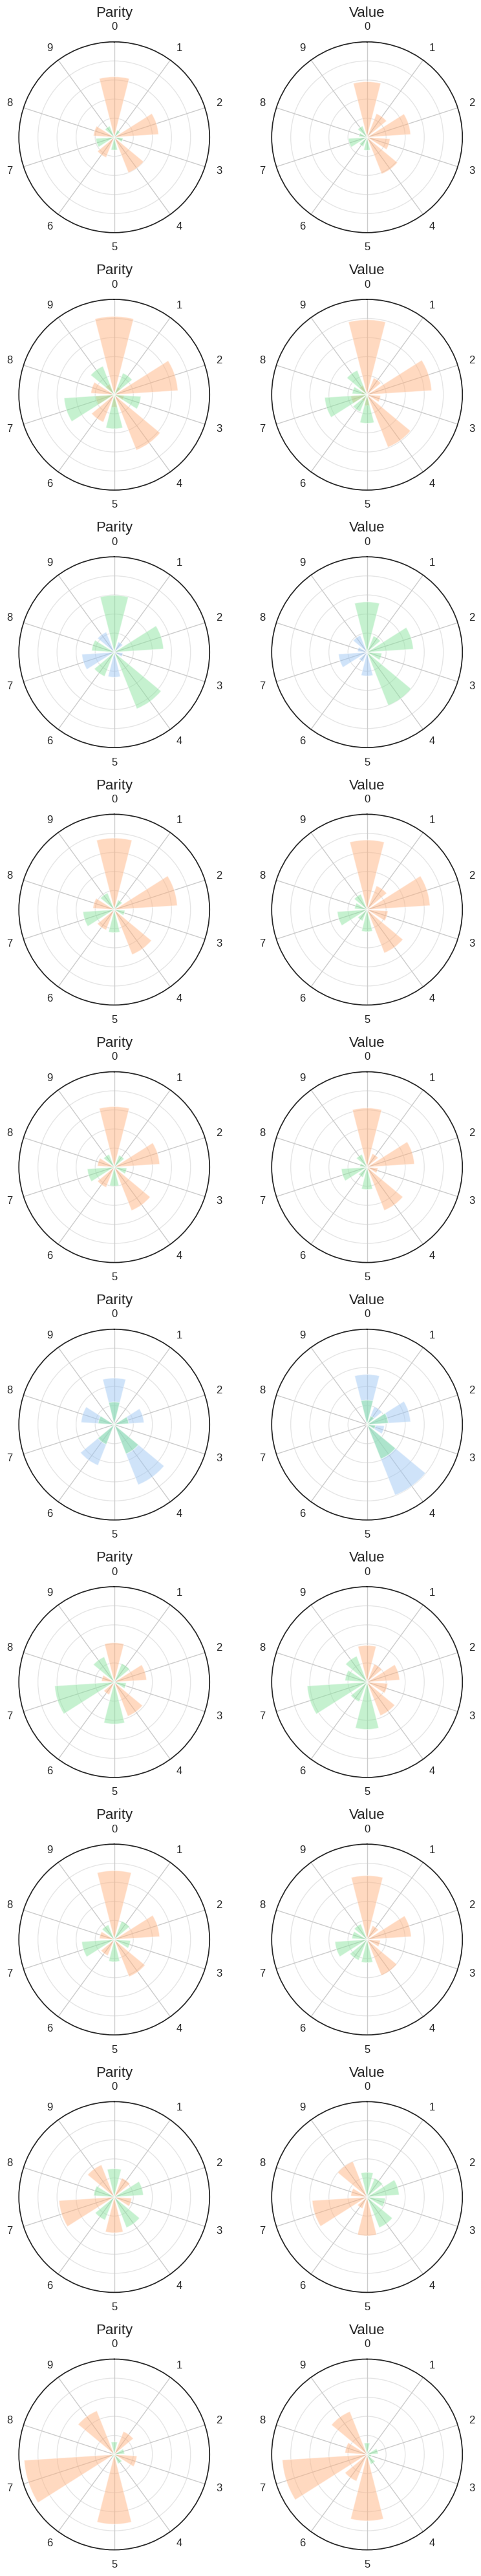

In [9]:
device = get_device()
criterion = nn.CrossEntropyLoss()
num_layers = len(num_hidden)

num_clusters = 3
num_digits = 10
theta = np.arange(0, 2 * np.pi, 2 * np.pi / num_digits)

fig, ax = plt.subplots(num_runs, num_tasks,
                       figsize=(4 * num_tasks, 4 * num_runs),
                       subplot_kw=dict(projection="polar"))

for i_seed, seed in tqdm(enumerate(seeds), total=num_runs):
    state_dict = results_task_switching[seed]['model']
    model = get_task_model(task_switching_tasks,
                           num_hidden,
                           idxs_contexts,
                           device)
    model.load_state_dict(state_dict)
    
    indices = results_task_switching[seed]['indices']

    test_sampler = dataset.SequentialSampler(indices['test'])
    _, test_dataloaders = dataset.create_dict_dataloaders(task_switching_tasks,
                                                          indices,
                                                          batch_size=batch_size)
    tasks_testloader = dataset.SequentialTaskDataloader(test_dataloaders)

    numbers = test_dataloaders[tasks_names[0]].dataset.numbers.numpy()
    numbers = numbers[indices['test']]

    _, activations = hooks.get_layer_activations(model,
                                                tasks_testloader,
                                                criterion,
                                                device=device,
                                                disable=True)


    avg_activations_units = np.zeros((num_hidden[0], num_tasks * num_digits))
    activations_cluster_all = np.zeros((num_tasks, num_clusters, num_digits))

    for i_task, task_name in enumerate(tasks_names):
        current_activations = activations[task_name]['layer10']
        for i_unit in range(num_hidden[0]):
            activation_unit = current_activations[:, i_unit]
            for i_digit in range(num_digits):
                avg_activations_units[i_unit, i_task * num_digits + i_digit] = np.mean(activation_unit[numbers == i_digit])
    
    avg_activations_units /= avg_activations_units.max()
    
    kmeans = KMeans(n_clusters=num_clusters, max_iter=300, n_init=10, random_state=1234).fit(avg_activations_units)
    cluster_labels = kmeans.labels_

    for i_cluster in range(num_clusters):
        activations_cluster = avg_activations_units[cluster_labels==i_cluster, :].mean(axis=0)
        
        for i_task in range(num_tasks):
            activations_cluster_all[i_task, i_cluster, :] = activations_cluster[num_digits * i_task: num_digits * (i_task + 1)]
    
    for i_task, task_name in enumerate(tasks_names):
        for i_cluster in range(num_clusters):
            data = activations_cluster_all[i_task, i_cluster]
            ax[i_seed, i_task].bar(theta, data, width=0.5, alpha=0.5)
        ax[i_seed, i_task].set_xticks(theta)
        ax[i_seed, i_task].set_yticklabels([])
        ax[i_seed, i_task].set_xticklabels(range(0, len(theta)), fontsize=12)
        ax[i_seed, i_task].yaxis.grid(True, alpha=.5)
        ax[i_seed, i_task].set_ylim(0, 1)
        ax[i_seed, i_task].set_theta_zero_location("N")
        ax[i_seed, i_task].set_theta_direction(-1)
        ax[i_seed, i_task].set_title(task_name.capitalize(), fontsize=16)

fig.tight_layout()
plt.show()

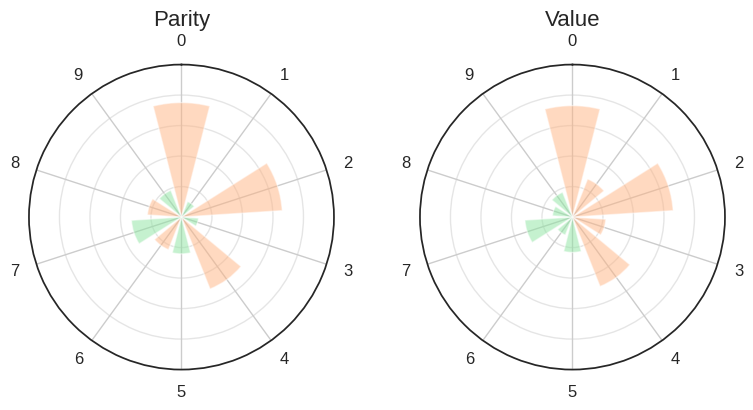

In [10]:
seed = seeds[3]
num_clusters = 3
layer = 'layer10'

fig, ax = plt.subplots(1, num_tasks, figsize=(4 * num_tasks, 4),
                 subplot_kw=dict(projection="polar"))

state_dict = results_task_switching[seed]['model']
model = get_task_model(task_switching_tasks,
                        num_hidden,
                        idxs_contexts,
                        device)
model.load_state_dict(state_dict)

indices = results_task_switching[seed]['indices']

test_sampler = dataset.SequentialSampler(indices['test'])
_, test_dataloaders = dataset.create_dict_dataloaders(task_switching_tasks,
                                                        indices,
                                                        batch_size=batch_size)
tasks_testloader = dataset.SequentialTaskDataloader(test_dataloaders)

numbers = test_dataloaders[tasks_names[0]].dataset.numbers.numpy()
numbers = numbers[indices['test']]

_, activations = hooks.get_layer_activations(model,
                                            tasks_testloader,
                                            criterion,
                                            device=device,
                                            disable=True)


avg_activations_units = np.zeros((num_hidden[0], num_tasks * num_digits))
activations_cluster_all = np.zeros((num_tasks, num_clusters, num_digits))

for i_task, task_name in enumerate(tasks_names):
    current_activations = activations[task_name][layer]
    for i_unit in range(num_hidden[0]):
        activation_unit = current_activations[:, i_unit]
        for i_digit in range(num_digits):
            avg_activations_units[i_unit, i_task * num_digits + i_digit] = np.mean(activation_unit[numbers == i_digit])

avg_activations_units /= avg_activations_units.max()

kmeans = KMeans(n_clusters=num_clusters, max_iter=300, n_init=10, random_state=1234).fit(avg_activations_units)
cluster_labels = kmeans.labels_

for i_cluster in range(num_clusters):
    activations_cluster = avg_activations_units[cluster_labels==i_cluster, :].mean(axis=0)
    
    for i_task in range(num_tasks):
        activations_cluster_all[i_task, i_cluster, :] = activations_cluster[num_digits * i_task: num_digits * (i_task + 1)]

for i_task, task_name in enumerate(tasks_names):
    for i_cluster in range(num_clusters):
        data = activations_cluster_all[i_task, i_cluster]
        ax[i_task].bar(theta, data, width=0.5, alpha=0.5)
    ax[i_task].set_xticks(theta)
    ax[i_task].set_yticklabels([])
    ax[i_task].set_xticklabels(range(0, len(theta)), fontsize=12)
    ax[i_task].yaxis.grid(True, alpha=.5)
    ax[i_task].set_ylim(0, 1)
    ax[i_task].set_theta_zero_location("N")
    ax[i_task].set_theta_direction(-1)
    ax[i_task].set_title(task_name.capitalize(), fontsize=16)

fig.tight_layout()
fig.savefig(path_figure_tasks)
plt.show()

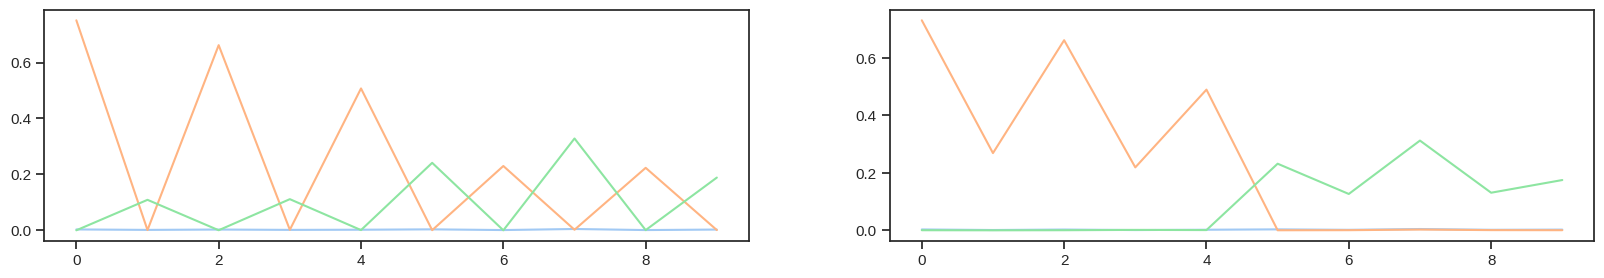

In [11]:
fig, ax = plt.subplots(1, num_tasks, figsize=(20, 3))

for i_cluster in range(1, num_clusters+1):    
    for i_task in range(num_tasks):
        ax[i_task].plot(activations_cluster_all[i_task, i_cluster-1, :])

plt.show()

In [12]:
task_switching_tasks = {}
num_tasks = len(tasks_names)

for i_context, task_name in enumerate(tasks_names):
    task_switching_tasks[task_name] = {}
    task_switching_tasks[task_name]['data'] = tasks_datasets[task_name]
    task_switching_tasks[task_name]['activations'] = num_tasks * [0]
    task_switching_tasks[task_name]['activations'][i_context] = 0

for key, value in task_switching_tasks.items():
    print(f'{key}: {value["activations"]}')

parity: [0, 0]
value: [0, 0]


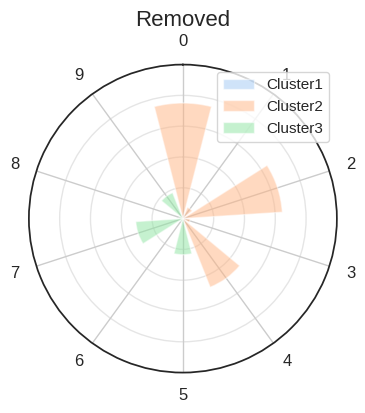

In [13]:
# num_clusters = 3
fig, ax = plt.subplots(1, 1, figsize=(4, 4),
                 subplot_kw=dict(projection="polar"))

state_dict = results_task_switching[seed]['model']
model = get_task_model(task_switching_tasks,
                        num_hidden,
                        idxs_contexts,
                        device)
model.load_state_dict(state_dict)

indices = results_task_switching[seed]['indices']

test_sampler = dataset.SequentialSampler(indices['test'])
_, test_dataloaders = dataset.create_dict_dataloaders(task_switching_tasks,
                                                        indices,
                                                        batch_size=batch_size)
tasks_testloader = dataset.SequentialTaskDataloader(test_dataloaders)

numbers = test_dataloaders[tasks_names[0]].dataset.numbers.numpy()
numbers = numbers[indices['test']]

_, activations = hooks.get_layer_activations(model,
                                            tasks_testloader,
                                            criterion,
                                            device=device,
                                            disable=True)

avg_activations_units = np.zeros((num_hidden[0], num_digits))
activations_cluster_all = np.zeros((num_clusters, num_digits))

current_activations = activations[tasks_names[0]][layer]  # All activations are the same!
for i_unit in range(num_hidden[0]):
    activation_unit = current_activations[:, i_unit]
    for i_digit in range(num_digits):
        avg_activations_units[i_unit, i_digit] = activation_unit[numbers == i_digit].mean()


max_avg = avg_activations_units.max()
avg_activations_units /= max_avg

for i_cluster in range(num_clusters):
    activations_cluster = avg_activations_units[cluster_labels==i_cluster, :].mean(axis=0)
    
    for i_task in range(num_tasks):
        activations_cluster_all[i_cluster, :] = activations_cluster

for i_cluster in range(num_clusters):
    data = activations_cluster_all[i_cluster]
    ax.bar(theta, data, width=0.5, alpha=0.5)
ax.set_xticks(theta)
ax.set_yticklabels([])
ax.set_xticklabels(range(0, len(theta)), fontsize=12)
ax.yaxis.grid(True, alpha=.5)
ax.set_ylim(0, 1)
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
ax.set_title('Removed', fontsize=16)

plt.legend(['Cluster1', 'Cluster2', 'Cluster3'])
fig.savefig(path_figure_removed)
plt.show()